In [3]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [4]:
# 개별 ML 모델
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier(random_state=0)
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 모델
lr_final = LogisticRegression(C=10)

In [5]:
# 개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [6]:
# 개별 모델 예측 데이터 셋 및 정확도
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

knn_acc = accuracy_score(y_test, knn_pred)
rf_acc = accuracy_score(y_test, rf_pred)
dt_acc = accuracy_score(y_test, dt_pred)
ada_acc = accuracy_score(y_test, ada_pred)

print(f'KNN 정확도: {knn_acc:.4f}')
print(f'랜덤 포레스트 정확도: {rf_acc:.4f}')
print(f'결정 트리 정확도: {dt_acc:.4f}')
print(f'에이다부스트 정확도: {ada_acc:.4f}')

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


#### n개의 모델을 통해 메타 데이터 만들기

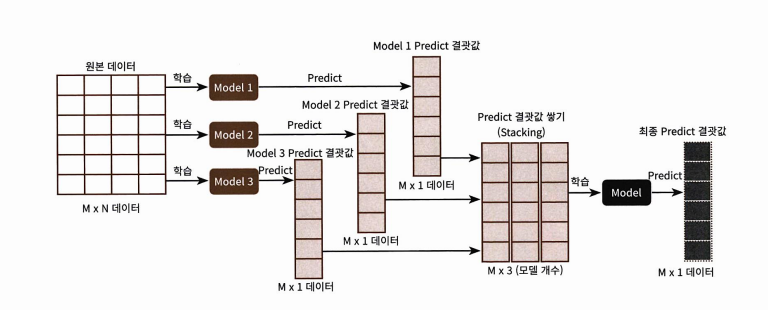

In [7]:
# 개별 예측 결과를 stacking
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# 개별 모델의 예측 결과를 피처로 생성
pred = pred.T
print(pred.shape)

(4, 114)
(114, 4)


In [10]:
# 예측 데이터로 생성된 데이터 세트 기반 최종 메타 모델인 로지스틱 회귀 학습 및 예측

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
lr_final_acc = accuracy_score(y_test , final)

print(f'최종 메타 모델의 예측 정확도: {lr_final_acc:.4f}')

최종 메타 모델의 예측 정확도: 0.9737


### CV 세트 기반 스태킹
##### 과적합 개선
##### 앞 예제에선 마지막 메타 모델 학습 시 테스트 데이터 세트 기반을 학습했기에 과적합 문제 발생 가능

##### 1. 각 모델별 원본 학습/테스트 데이터를 예측한 결과값을 기반으로 메타 모델을 위한 학습/테스트 데이터 생성
##### 2. 스텝1에서 생성한 학습 데이터를 모두 스태킹 형태로 합쳐 메타 모델이 학습할 최종 학습용 데이터 세트 생성. 테스트 데이터 세트도 마찬가지. 생성된 학습 데이터로 학습, 생성된 테스트 데이터를 테스트 데이터 에측, 원본 테스트 데이터를 기반으로 평가

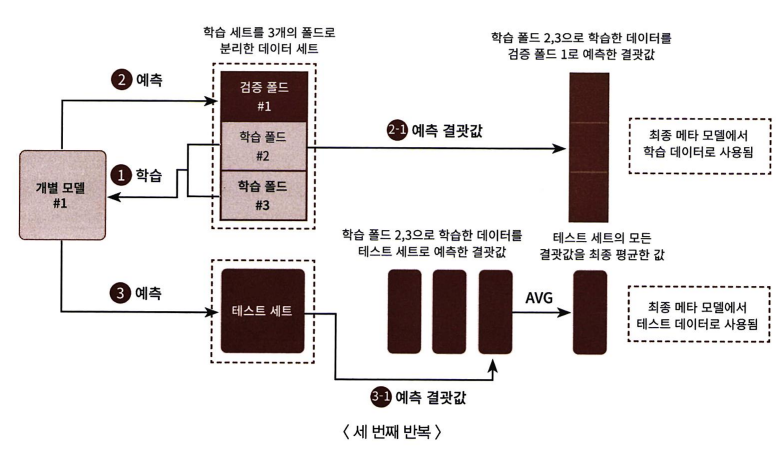

#### 스텝 1의 반복 과정

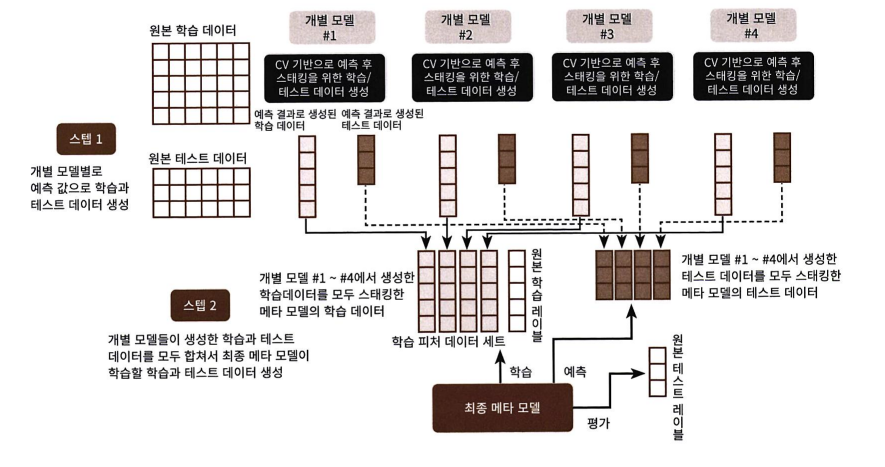

#### 스텝2의 반복 과정

In [33]:
# 스텝 1 코드
# 개별 모델과 메타 모델을 위한 학습용 데이터, 테스트 데이터 생성

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 모델별 메타 데이터
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    # 메타 데이터 반환을 위한 기본 배열
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
      # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트추출
      print('\t 폴드 세트:', folder_counter, '시작')
      X_tr = X_train_n[train_index]
      y_tr = y_train_n[train_index]
      X_te = X_train_n[valid_index]

      #폴드 세트 내부에서 다시 만들어진 학습 데이터로 모델 학습
      model.fit(X_tr, y_tr)
      #폴드 세트 내부에서 다시 만들어진 검증 데이터로 예측 후 저장
      train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
      #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 모델에서 예측 후 저장
      test_pred[:,folder_counter] = model.predict(X_test_n)

    #폴드 세트 내에서 원본 테스트 데이터 예측 후 데이터 평균해 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred,axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습데이터, 
    #test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean    


In [34]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier  model 시작 
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier  model 시작 
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier  model 시작 
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


In [35]:
#스텝2 구현 코드
# get_stacking_base_datasets() 호출로 반환된 각 모델별 학습 데이터와 테스트 데이터를 합침

Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train),axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test),axis=1)
print('원본 학습 피처 데이터 shape:',X_train.shape, '원본 테스트 피처 shape:',X_test.shape)
print('스태킹 학습 피처 데이터 shape:', Stack_final_X_train.shape)
print('스태킹 테스트 피처 shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 shape: (455, 30) 원본 테스트 피처 shape: (114, 30)
스태킹 학습 피처 데이터 shape: (455, 4)
스태킹 테스트 피처 shape: (114, 4)


In [39]:
# 최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 학습 레이블 데이터로 학습 
# 스태킹된 테스트 데이터 세트로 예측
# 예측 결과를 원본 테스트 레이블 데이터와 비교해 검증

lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델 예측 정확도: 0.9737


### 스태킹 시 개별 모델의 파라미터를 튜닝한 상태에서 스태킹 모델을 형성